# PHYS20762 - Project 2 - Numerical Integration of Differential Equations

Euan Baldwin - 10818421<br>
University of Manchester  
April 2023

## Introduction

This project will explore numerical methods for integration, namely the Euler, improved Euler, Verlet and Euler-Cromer methods by comparing them to the analytical solution for the displacement of a spring mass system, as well as the system's energy.  The project will then take the best numerical method and explore the impact of changing the damping constant and forcing the system.  The project will also investigate the resonant frequency of the system.

We first initialise the Python interpreter and import the necessary libraries.

In [1]:
# Initialisation
import string
import math
import cmath
import numpy as np
import matplotlib.pyplot as plt
from math import *
from scipy.optimize import curve_fit

## Numerical Constants

We define the numerical constants of the system as well as the total time over which we will be integrating and the array of time steps for the numerical integration methods.

In [2]:
SPRING_CONST = 2 # units: kg/s^2
MASS = 5.21 # units: kg
DISPLACEMENT_INITIAL = 0 # units: m
VELOCITY_INITIAL = -1 # units: m/s
DAMPING_CONST = 0.08 # units: kg/s
TIME_TOTAL = 140 # units: s
TIME_STEP = (0.005, 0.01, 0.05, 0.1) # units: s

## Setup & Analytical Method

We begin the main section by establishing a function to create arrays for the values of diplacement and velocity and assign the systems inital values to these arrays.

Next we define the analytical solution to the problem of a spring mass system with no external force applied.  The function returns the solution for the displacement of the equation: $m\ddot x(t) + b\dot x(t) + kx(t) = F(t)$, where $m$ is the mass (5.21 kg), $b$ is the damping constant (initially 0.08 kg/s), $k$ is the spring constant (2 kg/s$^2$), $F(t)$ is the external force applied on the system (initially 0 N) and $x(t), \dot x(t), \ddot x(t)$ are the displacement and its first and second derivatives respectively.

The solution is given by: $x(t) = \exp(-\frac{\gamma t}{2})(A\exp(j\omega t) + B\exp(-j\omega t))$

where $A$ and $B$ are constants given by the initial conditions, $\gamma = \frac{b}{m}$ is the damping ratio and $\omega^2 = \omega_0^2 - \frac{\gamma^2}{4}$ is the frequency, where $\omega_0 = \sqrt{\frac{k}{m}}$ is the natural frequency of the system.

A fitting test is then defined to evalute the goodness of fit of the various numerical integration methods compared to the analytical solution.  The test returns the mean percentage difference of the diplacement across the array.

Finally a simple function to calculate the system ernergy is established, where the system energy is given by: $\frac{1}{2} k x^2 + \frac{1}{2} m v^2$

In [3]:
def initial_setup(nsteps):
    # Create empty arrays ready for values of displacement and velocity
    displacement = np.zeros(nsteps)
    velocity = np.zeros(nsteps)
    
    # Assign initial conditions
    displacement[0] = DISPLACEMENT_INITIAL
    velocity[0] = VELOCITY_INITIAL
    return displacement, velocity


def analytical_method(time, damping_coefficient):
    # Define constants
    A = (damping_coefficient / (2*1j*cmath.sqrt(4*SPRING_CONST*MASS-damping_coefficient**2))+1/2)*DISPLACEMENT_INITIAL+VELOCITY_INITIAL*MASS/(cmath.sqrt(4*SPRING_CONST*MASS-damping_coefficient**2)*1j) 
    B = DISPLACEMENT_INITIAL - A

    # Calculate displacement
    displacement = np.exp(-damping_coefficient*time/(2*MASS))*(A*np.exp(1j*cmath.sqrt(4*SPRING_CONST*MASS-damping_coefficient**2)*time/(2*MASS))
                              +B*np.exp(-1j*cmath.sqrt(4*SPRING_CONST*MASS-damping_coefficient**2)*time/(2*MASS)))
    return displacement


def fit_test(observed, actual):
    # Define a valiable to store the total percentage diffference
    total_percent_difference = 0
    
    # Iterate through each value in the arrays
    for count, value in enumerate(actual):

        # Set value to zero for values that would otherwise return an invalid value error
        if observed[count] == value:
            percent_difference = 0
            
        # Calculate percentage difference between observed and actual values and add it to total difference
        else:
            percent_difference = abs((observed[count] - value) / value) * 100
        total_percent_difference += percent_difference
        
    # Calculate the average difference
    average_difference = total_percent_difference / len(actual)
    return average_difference


def energy_calculation(displacement, velocity):
    # Calculate the energy of the system
    return 1/2 * SPRING_CONST * displacement ** 2 + 1/2 * MASS * velocity ** 2

## Plotting the Different Methods

We set up a plotting functions for the plots in this section.  The first plot has two subplots, the first being of time against displacement and the second being of step size against goodness of fit compared to the analytical solution.  Another plotting function is defined for the plot of time against energy for the system.  We also establish a plotting routine to output the plots in an appropriate style.

In [4]:
def plot_routine():
    plt.rcParams.update({'font.size': 14}) # Set the text size to 14
    plt.style.use('default') # Use the dafault style
    plt.rcParams['figure.figsize'] = (12,3) # Set the figure size to (12,3)
    plt.rcParams['axes.autolimit_mode'] = 'round_numbers' # Set the axes to round numbers
    plt.grid() # Plot a grid
    plt.legend() # Display a legend
    plt.show() # Show the plot
    
    
def time_displacement_plot(method, time_step, damping_coefficient, title=None):
    plt.style.use('default') # Use the dafault style
    plt.rcParams['figure.figsize'] = (12,3) # Set the figure size to (12,3)
    fig,(ax1,ax2) = plt.subplots(1,2) # Add 2 subplots to the plot
    fig.suptitle(title)
    
    # Define an array to store goodness of fit values
    goodness_of_fit = np.zeros(len(time_step))
    
    # Calculate displacement for a specified method over range of step sizes 
    for i, step in enumerate(time_step):

        # Determine total number of steps and define an array of time values
        total_steps = math.ceil(TIME_TOTAL / step)
        time_array = np.arange(0, TIME_TOTAL, step)
                
        # Call and plot the specified method
        displacement, _ = method(total_steps, step, damping_coefficient)
        ax1.plot(time_array, displacement, label=f'Step = {step:.3f}')
        
        # Call the analytic solution
        analytical_displacement = analytical_method(time_array, damping_coefficient).real
        
        # Calculate and store the goodness of fit
        goodness_of_fit[i] = fit_test(displacement, analytical_displacement)
        
    # Plot the analytical solution
    ax1.plot(time_array, analytical_displacement, 'k--', label='Analytic Solution')

    # Set the time-displacement plot's axes labels and limits
    ax1.set(xlabel='Time (s)', ylabel='Displacement (m)')
    ax1.set_xlim([0, TIME_TOTAL])
    ax1.legend() # Display a legend
    ax1.grid() # Plot a grid
    
    # Set the goodness of fit plot's axes labels and limits
    ax2.plot(time_step, goodness_of_fit, '.r', label='data')
    ax2.set(xlabel='Step Size (s)', ylabel='Goodness of Fit (%)')
    
    # Call the plotting routine
    plot_routine()

    

def time_energy_plot(method, time_step, damping_coefficient):
    # Calculate system energy for a specified method over range of step sizes 
    for step in time_step:
            
        # Determine total number of steps and define an array of time values
        total_steps = math.ceil(TIME_TOTAL / step)
        time_array = np.arange(0, TIME_TOTAL, step)
        
        # Call the specified method
        displacement, velocity = method(total_steps, step, damping_coefficient)
        
        # Calculate and plot the system energy 
        energy = energy_calculation(displacement, velocity)
        plt.plot(time_array, energy, label=f'Step = {step:.3f}', lw=2)
    
    # Set the graph's axes labels and limits
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (J)")
    plt.ylim(0, 4)
    plt.xlim(0, TIME_TOTAL)
    
    # Call the plotting routine
    plot_routine()

### Euler's Method

Euler's method is a simple first-order method for solving ordinary differential equations (ODEs) with a given initial value.  The method's local error (error per step) is proportional to the square of the step size, and the global error (error at a given time) is proportional to the step size.

The acceleration, velocity and displacement are given by:<br>
$\ddot x[i] = -\frac{k}{m} x[i] - \frac{b}{m} \dot x[i]$<br>
$\dot x[i+1] = \dot x[i] + h\ddot x[i]$<br>
$x[i+1] = x[i] + h\dot x[i]$<br>
where $h$ is the time step being tested.

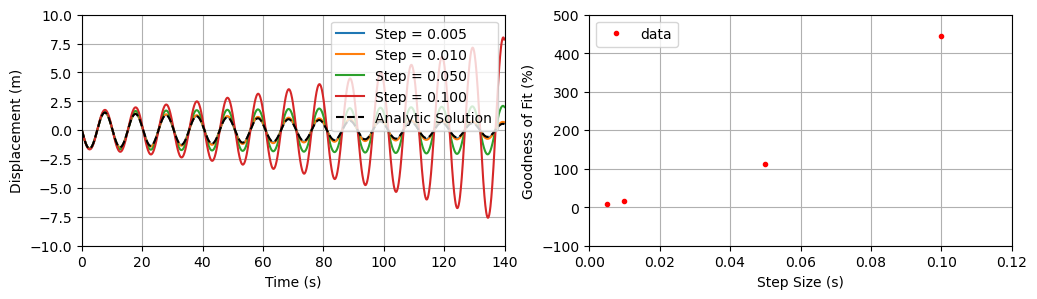

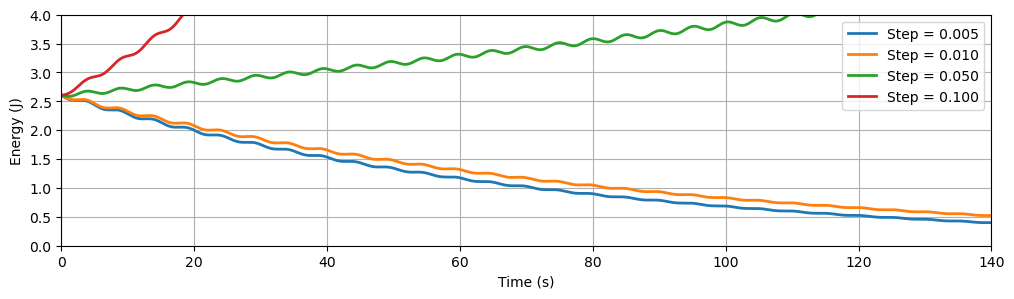

In [5]:
def euler_method(nsteps, hstep, damping_coefficient):
    # Complete the initial setup
    displacement, velocity = initial_setup(nsteps)

    # Calculate the acceleration at step i and the displacement and velocity at step i+1
    for i in range(nsteps - 1):
        acceleration = - (SPRING_CONST / MASS) * displacement[i] - (damping_coefficient / MASS) * velocity[i]
        displacement[i+1] = displacement[i] + velocity[i] * hstep
        velocity[i+1] = velocity[i] + acceleration * hstep
    return displacement, velocity 


# Call the plotting functions for Euler's method
time_displacement_plot(euler_method, TIME_STEP, DAMPING_CONST)
time_energy_plot(euler_method, TIME_STEP, DAMPING_CONST)

Euler's method showed poor accuracy to the analytical solution, with the displacement being an average of 7.9% away for even the most accurate step size trialled. As expected the general trend was that the smaller the step size the more accurate the solution, with the goodness of fit appearing to worsen with the square of the step size.  The larger step sizes incorrectly showed either constant or increasing system energy, despite the system being damped meaning we would expect decreasing system energy.

### Improved Euler's Method

The Improved Euler's method takes one extra term in the Taylor expansion for the derivative, theoretically making it more accurate than Euler's method.

The acceleration, velocity and displacement are given by:<br>
$\ddot x = -\frac{k}{m} x[i] - \frac{b}{m} \dot x[i]$<br>
$\dot x[i+1] = \dot x[i] + h\ddot x$<br>
$x[i+1] = x[i] + h\dot x[i] + \frac{h^2 \ddot x}{2}$

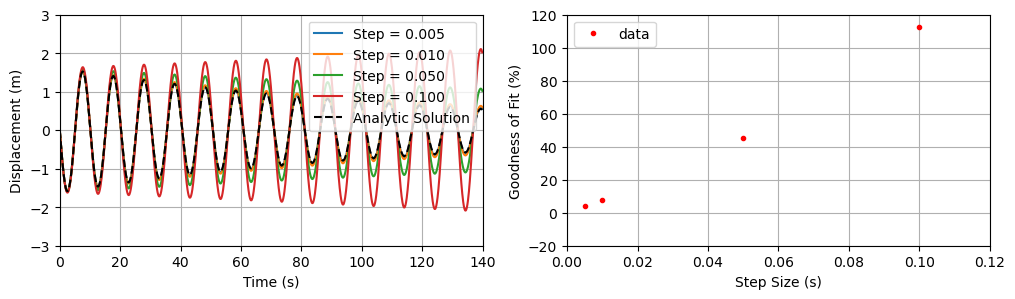

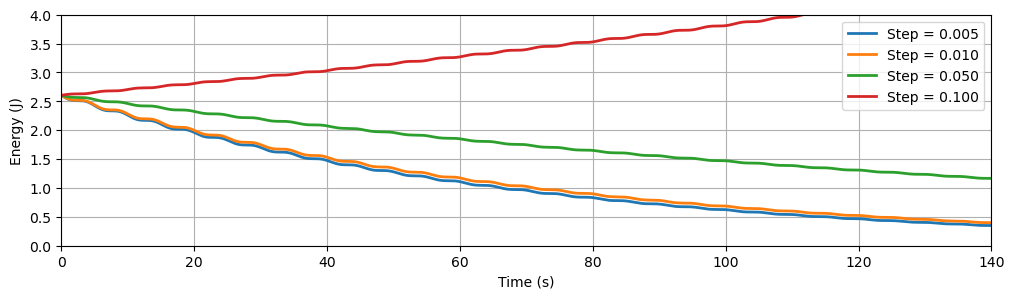

In [6]:
def improved_euler_method(nsteps, hstep, damping_coefficient):
    # Complete the initial setup
    displacement, velocity = initial_setup(nsteps)

    # Calculate the acceleration at step i and the displacement and velocity at step i+1
    for i in range(nsteps - 1):
        acceleration = - (SPRING_CONST / MASS) * displacement[i] - (damping_coefficient / MASS) * velocity[i]
        displacement[i+1] = displacement[i] + velocity[i] * hstep + (acceleration * hstep ** 2) / 2
        velocity[i+1] = velocity[i] + acceleration * hstep
    return displacement, velocity 


# Call the plotting functions for the Improved Euler's method
time_displacement_plot(improved_euler_method, TIME_STEP, DAMPING_CONST)
time_energy_plot(improved_euler_method, TIME_STEP, DAMPING_CONST)

The improved Euler's method showed similar results to Euler's method, although as expected the accuracy improved for all step sizes.  The smallest step size tested showed an average displacement to the analytical solution of 4.1%.  Furthermore, the method still incorrectly predicted constant or increasing system energy for the larger step sizes, though again accuracy was improved.

### Verlet's Method

Unlike the previous methods, Verlet's method uses a centred derivative making it significantly more accurate.  However this means it requires both the $[i-1]$ and $[i+1]$ values of displacement and one of these must be obtained using a different method.  To find these values we will use the most accurate method encountered so far: the Improved Euler method.

Furthermore, since this method is going to be used later in the project we will also include a term for the external force applied on the system, $F$.

The velocity and displacement are given by:<br>
$x[i+2] = 2 \frac{2m - h^2k}{2m + hb} x[i+1] + \frac{hb - 2m}{2m + hb} x[i] + h^2 F[i+1]$<br>
$\dot x[i+2] = \frac{x[i+2] - x[i]}{2h}$

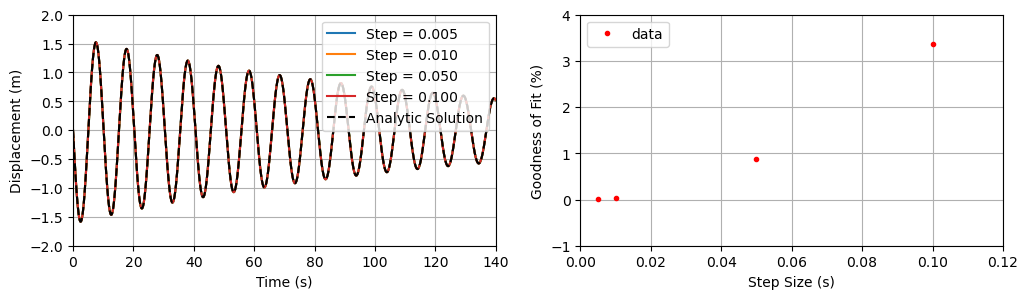

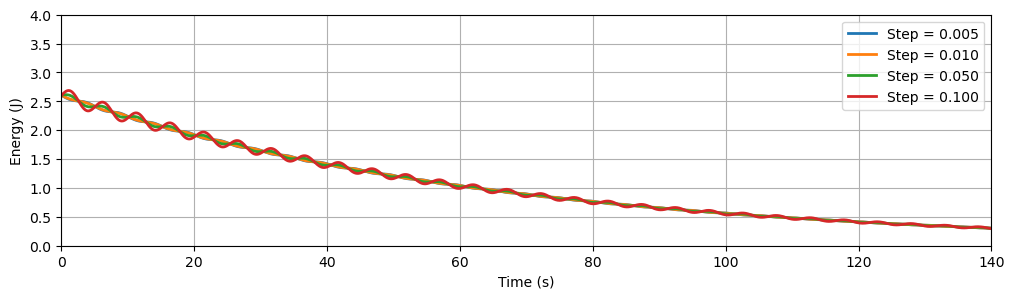

In [7]:
def verlets_method(nsteps, hstep, damping_coefficient, force=None):
    # Complete the initial setup
    displacement, velocity = initial_setup(nsteps)

    # Calculate the next displacement and velocity value using the Improved Euler method
    setup_array = improved_euler_method(2, hstep, damping_coefficient)
    displacement[1] = setup_array[0][1]
    velocity[1] = setup_array[1][1]
    
    # Define constants
    D = 2 * MASS + damping_coefficient * hstep
    A = 2 * (2 * MASS - SPRING_CONST * hstep ** 2) / D
    B = (damping_coefficient * hstep - 2 * MASS) / D
    
    # If no force is specified assume that the system is unforced
    if force is None:
        force = np.zeros(nsteps)

    # Calculate the displacement and velocity at step i+2
    for i in range(nsteps - 2):
        displacement[i+2] = A * displacement[i+1] + B * displacement[i] + (hstep ** 2 * force[i+1])
        velocity[i+2] = (displacement[i+2] - displacement[i]) / (2 * hstep)
    return displacement, velocity


# Call the plotting functions for Verlet's method
time_displacement_plot(verlets_method, TIME_STEP, DAMPING_CONST)
time_energy_plot(verlets_method, TIME_STEP, DAMPING_CONST)

Verlet's method showed the most accurate results, with the smallest two step sizes trialled resulting in the displacement being an average of less than 0.1% away from the analytical solution.  The method also correctly predicts decreasing system energy for all step sizes tested.  Further analysis will be done using this method.

### Euler-Cromer Method

The Euler-Cromer method is very similar to Euler's method, with the only difference being the $\dot x[i+1]$ term it used to calculate the displacement instead of the $\ddot x[i]$ term.  The result is that the method is a sympletic integrator, meaning that the overall energy is conserved, although there are still oscillations about this average value.

The velocity and displacement are given by:<br>
$\dot x[i+1] = \dot x[i] + h\dot x[i+1]$<br>
$x[i+1] = x[i] + h\dot x[i]$

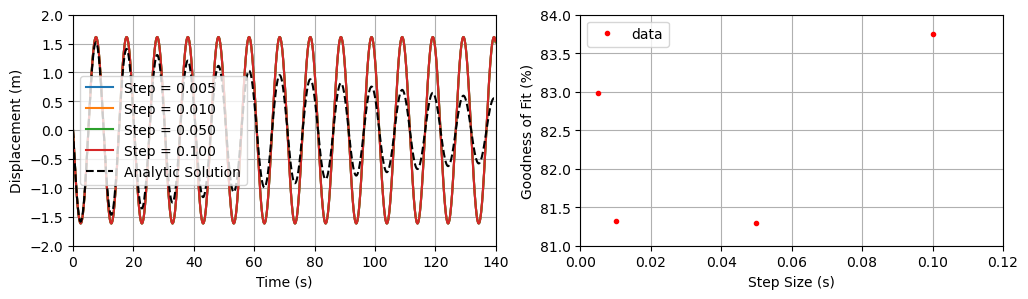

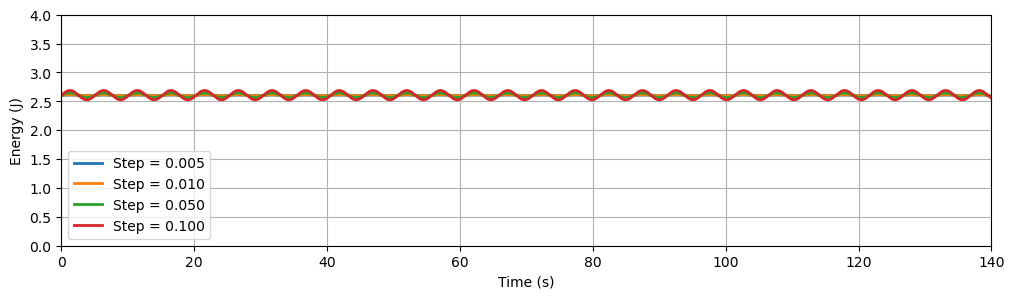

In [8]:
def euler_cromer_method(nsteps, hstep, damping_coefficient):
    # Complete the initial setup
    displacement, velocity = initial_setup(nsteps)
    
    # Calculate the displacement and velocity at step i+1
    for i in range(nsteps - 1):
        velocity[i+1] = velocity[i] - (displacement[i] * SPRING_CONST * hstep) / MASS
        displacement[i+1] = displacement[i] + hstep * velocity[i+1]
    return displacement, velocity 


# Call the plotting functions for the Euler-Cromer Method
time_displacement_plot(euler_cromer_method, TIME_STEP, DAMPING_CONST)
time_energy_plot(euler_cromer_method, TIME_STEP, DAMPING_CONST)

As expected the Euler-Cromer method gave results implying that the system had a constant (oscillating) energy and was undamped.  This meant that although the method was initially fairly accurate for all step sizes, its accuracy decreased over time as the damping became more significant and the amplitude of oscialltions should have decreased. Overall this meant that accuracy was around 81 to 84 per cent for all step sizes tested.

## Further Exploring the System using Verlet's Method

### Impact of varying the damping parameter around the value for critical damping

Critical damping is by definition the point between overdamping and underdamping where the oscillator returns to the equilibrium position as quickly as possible, without overshooting it.  The equation for the critical damping coefficient, $b_{cr}$, is given by: $b_{cr} = 2 \sqrt{km}$.  

The below graphs show the plots of displacement against time for Verlet's method with the first showing $b=b_{cr}$, the second showing $b=2b_{cr}$, and the last showing $b=\frac{1}{2}b_{cr}$.

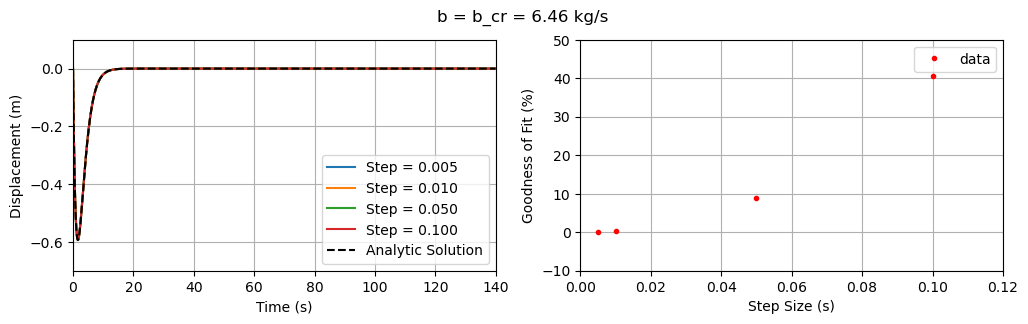

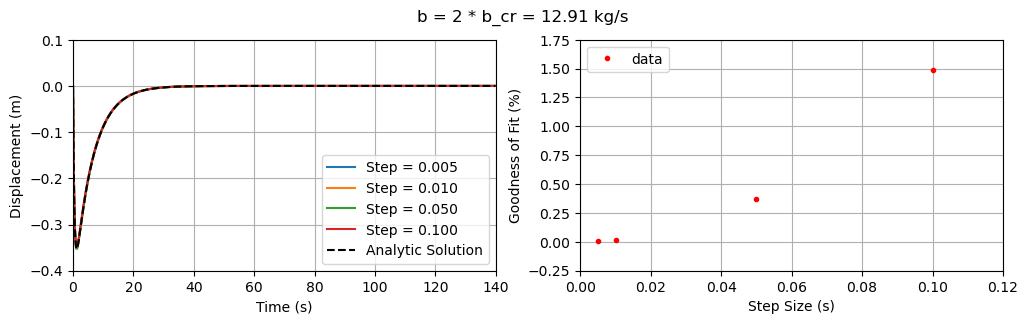

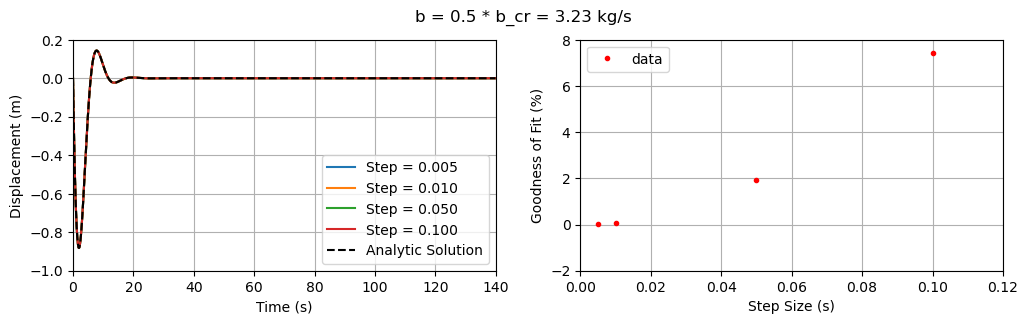

In [9]:
def crit_damping():
    # Calculate the critical damping coefficient
    return 2 * np.sqrt(SPRING_CONST * MASS)

# Call the plotting function for Verlet's method, setting the damping coefficient to its critical value
time_displacement_plot(verlets_method, TIME_STEP, crit_damping(), f'b = b_cr = {crit_damping():.2f} kg/s')

# Call the plotting function for Verlet's method, setting the damping coefficient to double its critical value
time_displacement_plot(verlets_method, TIME_STEP, 2*crit_damping(), f'b = 2 * b_cr = {2*crit_damping():.2f} kg/s')

# Call the plotting function for Verlet's method, setting the damping coefficient to half its critical value
time_displacement_plot(verlets_method, TIME_STEP, 1/2*crit_damping(), f'b = 0.5 * b_cr = {1/2*crit_damping():.2f} kg/s')

As expected the first graph ($b=b_{cr}$), shows the mass returning to the equilibrium point in as little time as possible without overshooting it.  The second graph ($b=2b_{cr}$) we expect to be over damped and this is shown by it taking longer to reach the equilibrium position.  Finally the last graph ($b=\frac{1}{2}b_{cr}$) was underdamped and this results in it overshooting the equilibrium position before settling at equilibrium a few oscillations later.

As shown all of the graphs showed a high degree of accuracy with the analytical solution.

### Impact of a sudden force on the system

We will now explore the impact of a sudden force on the system, looking at the impact of the direction of the force as well as the time at which the force is applied.

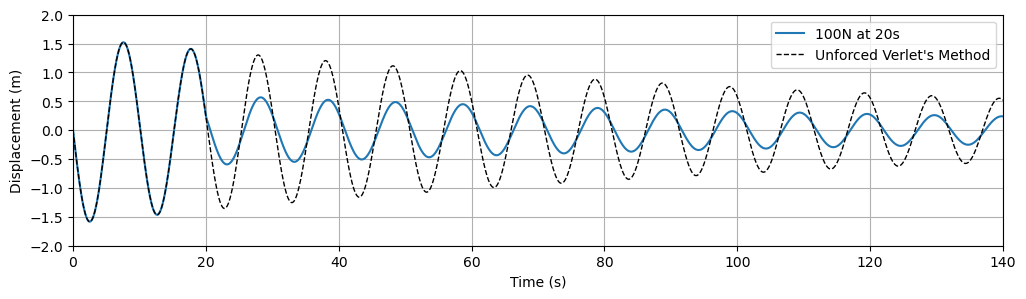

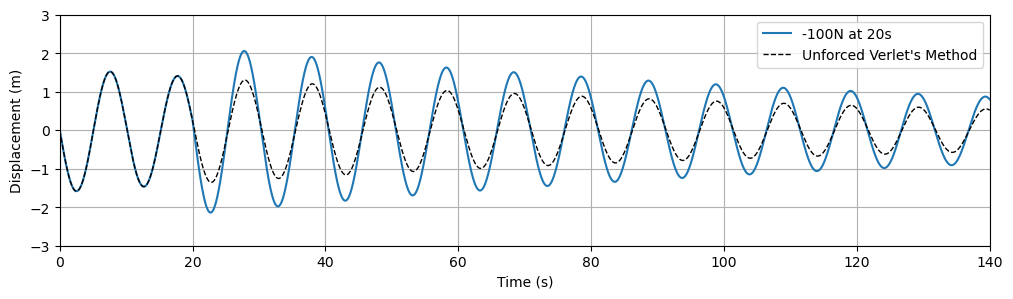

In [10]:
def force_plot(method, time_step, damping_coefficient, force=None, label_name=None):
    # Determine total number of steps and define an array of time values
    total_steps = math.ceil(TIME_TOTAL / time_step)
    time_array = np.arange(0, TIME_TOTAL, time_step)
    
    # Call and plot the specified method using the specified force and plot label
    displacement, _ = method(total_steps, time_step, damping_coefficient, force)
    plt.plot(time_array, displacement, label=label_name)
    
    # Call and plot the specifed method for an unforced system
    displacement_unforced, _ = method(total_steps, time_step, damping_coefficient)
    plt.plot(time_array, displacement_unforced, 'k--', label=f"Unforced Verlet's Method", lw=1)   
    
    # Set the graph's axes labels and limits
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement (m)")
    plt.xlim(0, TIME_TOTAL)
    
    # Call the plotting routine
    plot_routine()
    

def force_instantaneous(time_force, force_vector):
    # Determine total number of steps and the step at which the force is applied
    step_total = math.ceil(TIME_TOTAL / TIME_STEP[0])
    step_force = math.ceil((time_force / TIME_TOTAL) * step_total)
    
    # Define an array for the force, setting values to zero
    force = np.zeros(step_total)
    
    # Set value at which the force is applied to the force vector
    force[step_force] = force_vector
    return force

# Call the plotting function for Verlet's method (step size 0.05s) with an instantaneous force of 100N at 20s
force_plot(verlets_method, TIME_STEP[0], DAMPING_CONST, force_instantaneous(20, 100), '100N at 20s')

# Call the plotting function for Verlet's method (step size 0.05s) with an instantaneous force of -100N at 20s
force_plot(verlets_method, TIME_STEP[0], DAMPING_CONST, force_instantaneous(20, -100), '-100N at 20s')

The above plots show a force of 100N and -100N respectively being applied on the system at 20s, which is roughly when the mass passes through the equilibrium point.  At this point the mass will have a maximum negative displacement so we would expect the positive force to severly reduce the amplitude of osciallations as it acts against the direction of acceleration, and the negative force to greatly increase the amplitude as it acts in the same direction as the acceleration.  This happens as expected.

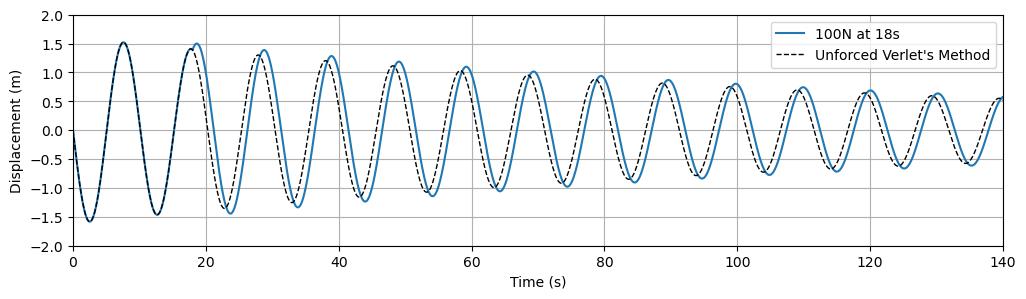

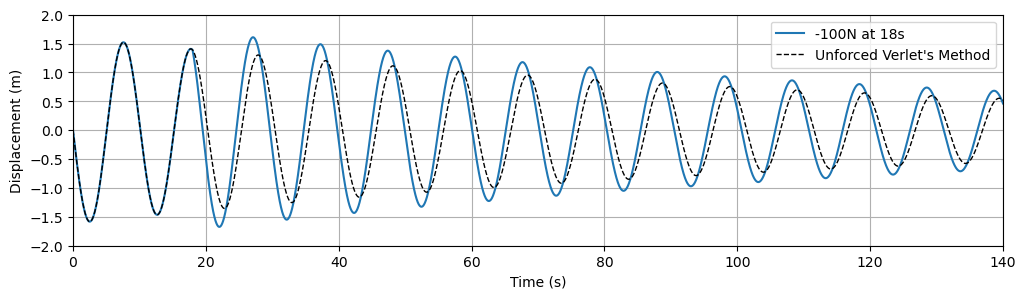

In [11]:
# Call the plotting function for Verlet's method (step size 0.05s) with an instantaneous force of 100N at 18s
force_plot(verlets_method, TIME_STEP[0], DAMPING_CONST, force_instantaneous(18, 100), '100N at 18s')

# Call the plotting function for Verlet's method (step size 0.05s) with an instantaneous force of -100N at 18s
force_plot(verlets_method, TIME_STEP[0], DAMPING_CONST, force_instantaneous(18, -100), '-100N at 18s')

We now show the same forces as above (100N and -100N) being applied on the system at 18s, which is roughly when the mass is at its maximum displacement.  

At this point the mass will have maximum negative acceleration and hence we would expect the external forces to have a smaller impact.  The 100N force acts to slightly increase the amplitude of the maximum at which its applied as it works against the direction of acceleration, resulting in future osciallations also having a greater displacement.  

The -100N force acts to increase the displacement of the next maximum/minimum amplitude as it acts in the same direction as the acceleration, also resulting in future osciallations having a greater displacement.

### Impact of a continuous force on the system

We will now explore the impact of a continuous sinusoidal force on the system, looking at the impact of the frequency of the force as well as the time over which the force is applied.  The forces will take the form $F(t) = F_0sin(\omega t)$.

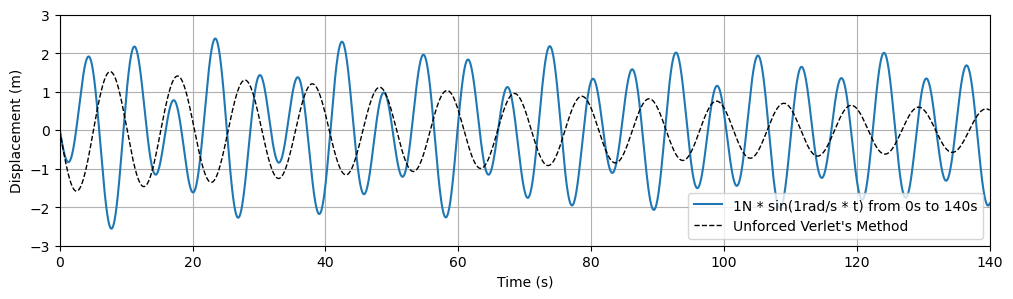

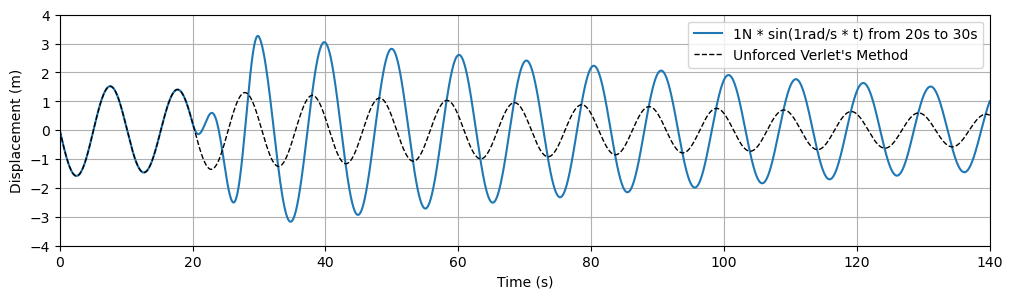

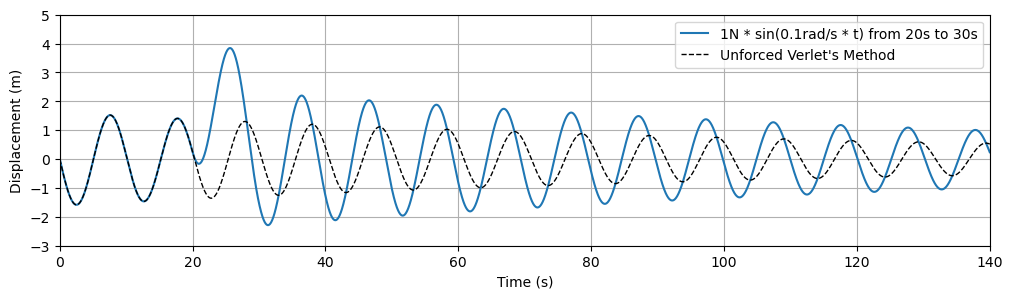

In [12]:
def force_continuous(time_force_start, time_force_end, force_vector, frequency): 
    # Determine total number of steps and the steps at which the force starts and ends
    step_total = math.ceil(TIME_TOTAL / TIME_STEP[0])
    step_force_start = math.ceil((time_force_start / TIME_TOTAL) * step_total)
    step_force_end = math.ceil((time_force_end / TIME_TOTAL) * step_total)
    
    # Define an array for the force, setting values to zero
    force = np.zeros(step_total)
    
    # Set values over which the force is applied to the force vector
    for step, _ in enumerate(force):
        if step > step_force_start and step < step_force_end:
            time = step / step_total * TIME_TOTAL
            force[step] = force_vector * np.sin(frequency * time)
    return force

# Call the plotting function for Verlet's method (step size 0.05s) with a force of 1N * sin(1rad/s * t) from 22s to 32s
force_plot(verlets_method, TIME_STEP[0], DAMPING_CONST, force_continuous(0, 140, 1, 1), '1N * sin(1rad/s * t) from 0s to 140s')

# Call the plotting function for Verlet's method (step size 0.05s) with a force of 1N * sin(10rad/s * t) from 20s to 30s
force_plot(verlets_method, TIME_STEP[0], DAMPING_CONST, force_continuous(20, 30, 1, 1), '1N * sin(1rad/s * t) from 20s to 30s')

# Call the plotting function for Verlet's method (step size 0.05s) with a force of 1N * sin(0.1rad/s * t) from 20s to 30s
force_plot(verlets_method, TIME_STEP[0], DAMPING_CONST, force_continuous(20, 30, 1, 0.1), '1N * sin(0.1rad/s * t) from 20s to 30s')

The first graph shows the impact of the force, $F(t) = 1Nsin(1 \frac{rad}{s}t)$, applied from zero to 140 seconds.  The force causes the oscillations to be a superposition of the orginal oscillation sine wave and the new force sine wave.  A Fourier Transform could be used to decompose the resultant sine wave into the two orginal waves.

The second and third graphs show $F(t) = 1Nsin(1 \frac{rad}{s}t)$ and $F(t) = 1Nsin(0.1 \frac{rad}{s}t)$ respectively being applied from twenty to thirty seconds.  It is crucial to note that the system returns to steady oscillations after the transient period.

Both forces show significantly greater impact on the amplitude of osciallations compared to the sudden force applications despite being one hundredth the strength.  This is due to the forces being applied continuously over the application period meaning their total contribution is greater than in the instantaneous force case.  However it is evident that the higher frequency force results in higher amplitude osciallations suggesting that the frequency of the force is closer to the resonant frequency of the system.

### Investigating the resonance of the system

Finally we will look at the impact of varying the frequency, $\omega$, of the system around the resonant frequency, $\omega_0 = \sqrt{\frac{k}{m}}$.  We expect the amplitude and frequency to have the following relation: 
$amplitude = \frac{\frac{F_0}{m}}{\sqrt{((\omega_0^2-\omega^2)^2+\omega^2\gamma^2)}}$ and we will use curve fit, a non-linear least squares fit from the scipy.optimize package, to fit this function to our data.

The resonant frequency using Verlet's Method was: 0.6196 ± 0.0001 rad/s,
The resonant frequency calculated analytically was: 0.6196 rad/s


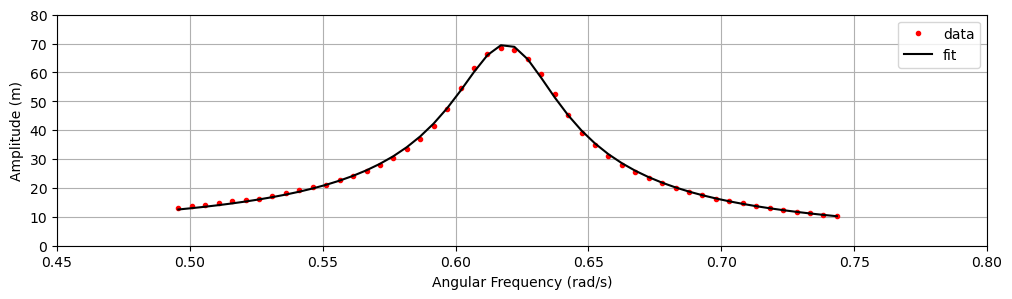

In [13]:
def resonant_frequency_calc():
    # Calculate the resonant frquency of the system
    return np.sqrt(SPRING_CONST / MASS)


def resonance_plot(method, time_step, damping_coefficient, number_of_frequencies):
    # Determine total number of steps
    total_steps = math.ceil(TIME_TOTAL / time_step)

    # Define an array to store amplitudes
    amplitude = np.zeros(number_of_frequencies)
    
    # Define an array of a specified number of frequencies ranging from 0.8 to 1.2 times the resonant frequency
    frequencies = np.linspace(0.8*resonant_frequency_calc(), 1.2*resonant_frequency_calc(), number_of_frequencies)
    
    # Iterate through the frequencies, storing the maximum displacement of the oscillations
    for i, omega in enumerate(frequencies):
        force = force_continuous(0, TIME_TOTAL, 1, omega)
        displacement, _ = method(total_steps, time_step, damping_coefficient, force)
        amplitude[i] = max(displacement)
    
    # Plot values of frequency against amplitude
    plt.plot(frequencies, amplitude, '.r', label='data')
    
    # Calculate and plot the line of best fit for frequency against amplitude
    fit, fit_resonant_frequency, fit_resonant_frequency_error = fitting_func(amplitude_func, frequencies, amplitude)
    plt.plot(frequencies, fit, '-k', label='fit')
    
    # Print the fitted resonant frequency, its error and the analytically calculated resonant frequency
    print(f"The resonant frequency using Verlet's Method was: {fit_resonant_frequency:.4f} ± {fit_resonant_frequency_error:.4f} rad/s,"
          f"\nThe resonant frequency calculated analytically was: {resonant_frequency_calc():.4f} rad/s")
    
    # Set the graph's axes labels
    plt.xlabel("Angular Frequency (rad/s)")
    plt.ylabel("Amplitude (m)")
    
    # Call the plotting routine
    plot_routine()
    
    
def amplitude_func(frequency, resonant_frequency, external_force, mass, damping_coefficient):
    # Equation of parameters to optimise in fitting process
    return (external_force / mass) / np.sqrt((resonant_frequency ** 2 - frequency ** 2) ** 2 + frequency ** 2 * (damping_coefficient / mass) ** 2)

    
def fitting_func(func, frequencies, amplitude):
    popt, pcov = curve_fit(func, frequencies, amplitude) # Calculate optimised parameters and their covariance
    yfit = func(frequencies, *popt) # Use optimised parameters to create a line of best fit
    perr = np.sqrt(np.diag(pcov)) # Calculate errors by finding diagonalisation of covariance matrix
    return yfit, popt[0], perr[0] # Return line of best fit and optimised value and error for resonant frequency


# Call the resonant plotting function for Verlet's method (step size 0.05s) with 50 frequencies
resonance_plot(verlets_method, TIME_STEP[0], DAMPING_CONST, 50)

#### 

The above plot and printed statement clearly demonstrate that Verlet's method has accurately estimated the resonant frequency of the system as found analytically.  As expected from the relation between amplitude and frequency, as $\omega$ tends to zero, the amplitude appears to tend to $\frac{F_0}{m\omega_0^2}$ and as $\omega$ tends to infinity, the amplitude appears to tend zero.  Furthermore the resonant frequency corresponds to an amplitude of $\frac{F_0}{m\omega_0 \gamma}$.